In [193]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re
import nltk
import pickle
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

import plotly.express as px
from matplotlib import pyplot as plt
%matplotlib inline


### Загрузка и предобработка данных

In [194]:
data = pd.read_csv('train_tin.csv', encoding='mbcs')
test = pd.read_csv('test_tin.csv', encoding='mbcs')
data.head()

,text,isPositive
0,"27.09.19 через сайт в разделе ""Рефинансировани...",0
1,Добрый день! Неоднократно поступают звонки по ...,0
2,В первый раз решила воспользоваться кредитной ...,0
3,На самом дело уже накипело из-за участившегося...,0
4,Если вы дорожите своими нервами - ни при каких...,0


In [198]:
test.drop(['isPositive'], axis=1, inplace=True)
test.head(2)

,text
0,Добрый день! Я являюсь клиентом Тинькофф банк ...
1,Хочу выразить огромную благодарность банку Тин...


In [195]:
# Распределение классов
data['isPositive'].value_counts()

0    1975
1    1975
Name: isPositive, dtype: int64

In [196]:
# Пример отзыва
data.loc[4,'text']

'Если вы дорожите своими нервами - ни при каких обстоятельствах не имейте дел с кредитными продуктами этого банка!В Тинькофф-банке у меня была оформлена кредитная карта и потребительский кредит. Кредит я оформила в августе, по графику платежей я\xa0должна была вносить по нему 4820 руб. 7-го числа каждого месяца, начиная с\xa0сентября.Кредитной картой год не пользовалась вообще, в июле этого года сняла с нее 20 000 тыс. 1 августа полностью погасила всю сумму\xa0задолженности, которую на тот момент видела в своем интернет-банке\xa0(долг+проценты) и была полностью уверена, что по кредитке я больше ничего не\xa0должна.\xa026 сентября мне поступает первое за все время смс-сообщение банка, что у меня просрочен платеж по кредитной карте на сумму 143 руб. и будет\xa0начислен штраф. Я ни разу в жизни не допускала просрочек по кредитам, и,\xa0конечно, была в шоке. Звоню в банк и выясняю, что уже после внесения мной\xa0платежа проценты по кредитке были доначислены.\xa0Никаких оповещений я об\xa0э

In [199]:
# Чистим тексты с помощью регуярок
expr =  r'[\d+\W+\s_]'
train = list(map(lambda x: (re.sub(expr, ' ', x)).lower(), data.text))
test = list(map(lambda x: (re.sub(expr, ' ', x)).lower(), test.text))

In [200]:
expr =  r'\sго\s'
train = list(map(lambda x: (re.sub(expr, ' ', x)), train))
test = list(map(lambda x: (re.sub(expr, ' ', x)), test))

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\proho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
sw_ru = set(stopwords.words('russian'))
len(sw_ru)

151

In [9]:
list(sw_ru)[:10]

['не', 'том', 'быть', 'ли', 'может', 'вам', 'тогда', 'иногда', 'он', 'него']

In [10]:
# Удаление стоп слов
sent = train[0]
clean_sent = ' '.join([word for word in sent.split() if not word in sw_ru])
print('До {} слов'.format(len(sent.split())))
print('После {} слов'.format(len(clean_sent.split())))


До 457 слов
После 293 слов


In [201]:
train = list(map(lambda sent: ' '.join([word for word in sent.split() if not word in sw_ru]), train))
test = list(map(lambda sent: ' '.join([word for word in sent.split() if not word in sw_ru]), test))

In [202]:
len(train[0].split())

293

In [13]:
!pip install pymorphy2

^C


In [203]:
import pymorphy2
def my_lemmatizer_ru(sent):
    lemmatizer = pymorphy2.MorphAnalyzer()
    tokenized_sent = sent.split()
    return ' '.join([lemmatizer.parse(word)[0].normal_form
                    for word in tokenized_sent])

In [15]:
# Так как лемматизация занимает немало времени, я сохранил лемматизированный текст в файл, чтобы не ждать заново в случае чего

# train_lem = list(map(lambda sent: my_lemmatizer_ru(sent), train))

In [205]:
# test_lem = list(map(lambda sent: my_lemmatizer_ru(sent), test))

In [172]:
# Сохранение текста

# output = open('data_lem.pkl', 'wb')
# pickle.dump(train_lem, output)
# output.close()

In [207]:
# output = open('test_lem.pkl', 'wb')
# pickle.dump(test_lem, output)
# output.close()

In [208]:
pkl_file = open('data_lem.pkl', 'rb')
train_lem = pickle.load(pkl_file)
pkl_file.close()

In [209]:
pkl_file = open('test_lem.pkl', 'rb')
test_lem = pickle.load(pkl_file)
pkl_file.close()

In [212]:
train_lem[0][:1000]

'сайт раздел рефинансирование сторонний кредит заполнить заявка рефинансирование кредит указать банк сумма задолженность кредит который хотеть закрыть следом поступить звонок обзвонить оставить контакт приходить смс одобрение заявка кредит дословно заявка кредит одобрить пожалуйста дождаться звонок сотрудник следующий день звонок банк сотрудник радостно сообщать банк одобрить ранее оставить заявка рефинансирование озвучить ставка устроить сумма сумма почему оказаться маленький указанный заявка который собственно составлять сумма задолженность запрашивать логичный вопрос почему сотрудник алексей вразумительный ответ предоставить мочь лишь постоянно требовать ответ другой продукт который мочь рефинансировать прокомментировать иметься также карта альфа банк день лп который успешно пользоваться переводить выплата банк тинькофф карта который кроме годовой банковский обслуживание желание никакой иметь итог согласиться получение одобрить сумма пусть достаточно полный закрытие указанный кредит

#### Создание embendding-ов

In [213]:
idf_vectorizer = TfidfVectorizer()

In [214]:
idf_vectorizer.fit(train_lem)

tf_idf_train = idf_vectorizer.transform(train_lem)

In [215]:
tf_idf_train

<3950x16274 sparse matrix of type '<class 'numpy.float64'>'
	with 290100 stored elements in Compressed Sparse Row format>

In [216]:
data['isPositive']

0       0
1       0
2       0
3       0
4       0
       ..
3945    1
3946    1
3947    1
3948    1
3949    1
Name: isPositive, Length: 3950, dtype: int64

In [217]:
X_train, X_test, y_train, y_test = train_test_split(
    tf_idf_train, data['isPositive'], test_size=0.1, random_state=42)

In [218]:
model = XGBClassifier()
model.fit(X_train, y_train)

C:\Users\proho\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[12:26:41] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [219]:
# Результат tf-idf и бустинга
# Так как классы в выборке сбалансированы буду использовать accuracy

preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.8911392405063291

#### Визуализация embendding-ов tf-idf

In [220]:
tsne = TSNE(n_components=2, n_iter=400)

X_tsne_2 = tsne.fit_transform(tf_idf_train)

C:\Users\proho\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:764: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\proho\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:774: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



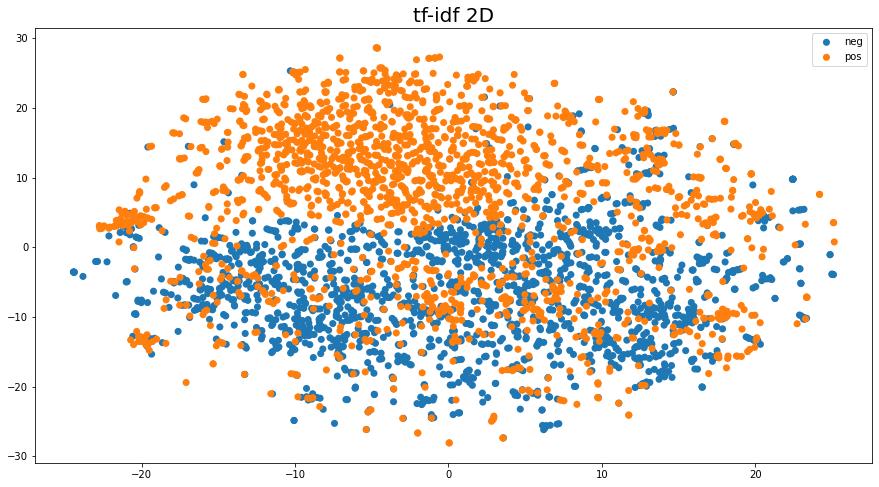

In [221]:
plt.figure(figsize=(15, 8))


plt.scatter(X_tsne_2[:1975, 0],
            X_tsne_2[:1975, 1],
            label='neg', edgecolor='none', s=50)
plt.scatter(X_tsne_2[1975:, 0],
            X_tsne_2[1975:, 1],
            label='pos', edgecolor='none', s=50)
plt.title(u"tf-idf 2D", fontsize=20)
plt.legend()

In [223]:
tsne = TSNE(n_components=3, n_iter=400)

X_tsne_3 = tsne.fit_transform(tf_idf_train)


In [224]:
d = {'target': list(data['isPositive']),
    'x': X_tsne_3[:, 0],
    'y': X_tsne_3[:, 1],
    'z': X_tsne_3[:, 2]}
df = pd.DataFrame(data = d)
df

,target,x,y,z
0,0,3.039098,1.548401,9.476599
1,0,12.649659,-8.157672,10.887788
2,0,0.433717,-8.800058,-1.004523
3,0,2.726078,-0.526469,-9.760009
4,0,3.777654,-8.787813,4.231185
...,...,...,...,...
3945,1,-10.843516,2.344574,-1.727709
3946,1,3.263945,-15.531296,-6.401266
3947,1,-6.221197,-1.569199,8.256696
3948,1,-2.060089,6.057448,0.256774


In [225]:
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color='target',
                    title="tf-idf 3D")

fig.update_layout(width=800, height=800)
fig.show()

#### Применю word2vec

In [226]:
train_lem_split = list(map(lambda x: x.split(), train_lem))
test_lem_split = list(map(lambda x: x.split(), test_lem))

In [234]:
all_text = np.concatenate([train_lem_split, test_lem_split])

In [235]:
model = Word2Vec(min_count = 5, seed = 1, workers = 1)

In [236]:
model.build_vocab(all_text)
model.train(all_text, total_examples=model.corpus_count, epochs=30, report_delay=1)

(12814465, 14933580)

In [237]:
len(model.wv)

5692

In [239]:
model.wv.most_similar(positive=["тинькофф"])

[('тинькоф', 0.7288855910301208),
 ('тиньковы', 0.5802098512649536),
 ('тинкофф', 0.49012356996536255),
 ('тб', 0.42068129777908325),
 ('данный', 0.4087657928466797),
 ('ткс', 0.3871614933013916),
 ('райффайзный', 0.373799204826355),
 ('порекомендовать', 0.36611172556877136),
 ('отличный', 0.3608015477657318),
 ('давно', 0.3557325303554535)]

In [240]:
model.wv["банк"]

array([ 6.1487284e-02,  7.4150419e-01,  3.2910004e-01,  1.7012941e+00,
       -8.7183571e-01,  2.2938064e-01, -8.9283407e-02,  5.4002088e-01,
       -2.6296442e-02, -7.5299871e-01,  1.4887160e+00,  4.8210269e-01,
       -8.9564931e-01,  6.2290859e-01,  9.3500680e-01, -1.9942187e-01,
        4.7142437e-01,  9.6978736e-01, -9.9096060e-01,  1.3288689e+00,
       -2.5302442e-02, -9.0159856e-02,  3.3987728e-01,  7.4891090e-01,
        5.4503530e-01,  7.9922605e-01, -2.4978390e-01,  5.0292557e-01,
        1.8027686e-01, -4.1380741e-02, -8.7205762e-01, -3.3787549e-01,
        7.5361359e-01,  9.7835243e-02,  1.0960272e-01, -6.8430519e-01,
       -4.0663861e-02, -4.2595720e-01, -1.5441689e+00,  7.6380867e-01,
       -8.0961752e-01,  1.2234402e+00,  9.8033600e-02, -1.3239090e+00,
        3.5606578e-01, -1.6301082e-01, -2.5425252e-01,  1.2653576e+00,
        1.3359123e-01, -5.4155785e-01, -1.0728928e+00,  6.7204314e-01,
        1.8878660e-01, -2.8762266e-01,  1.5411373e+00, -4.7384554e-01,
      

In [242]:
def mean_vec(model, text):
    vec = np.array([0.]*100)
    for word in text:
        if word not in model.wv.index_to_key:
            v = np.zeros(100)
            vec += v
        else:
            vec += model.wv.word_vec(word)
    return vec/len(text)

In [243]:
all_word2vec = list(map(lambda x: mean_vec(model,x), all_text))

C:\Users\proho\AppData\Local\Temp/ipykernel_12380/1435866780.py:8: DeprecationWarning:

Call to deprecated `word_vec` (Use get_vector instead).



In [244]:
all_word2vec[1]

array([-0.08304233, -0.43124052, -0.25646026,  0.29191844, -0.28523144,
        0.50525067,  0.3554146 , -0.41185347, -0.05319012, -0.41242278,
        0.53637407,  0.05128345, -0.2091542 , -0.26762097,  0.4320404 ,
       -0.18698577, -0.90381914,  0.09468252, -0.42114369,  0.58243408,
       -0.35375422,  0.14987269, -0.46333576,  0.23943373,  0.30667524,
       -0.06663662,  0.18948771,  0.16792317,  0.04112487, -0.42307602,
       -0.40070345,  0.26150807,  0.10397854, -0.40256128, -0.15896838,
        0.0701428 ,  0.06385723, -0.28418448, -0.46185068,  0.47248011,
        0.02475375,  0.10500846,  0.40622627, -0.55316212, -0.07281605,
        0.26078859, -0.40317121, -0.07428431, -0.53010887, -0.48297049,
        0.25669091, -0.26452964, -0.09479501, -0.44624718,  0.14579933,
       -0.15682385, -0.09091168,  0.45897387, -0.16317628,  0.33250117,
       -0.39132371, -0.29674726,  0.41845377, -0.20045708, -0.13930052,
       -0.15093898, -0.19525633,  0.45401441,  0.38971907, -0.01

In [245]:
train_word2vec = all_word2vec[:len(train_lem_split)]
test_word2vec = all_word2vec[len(train_lem_split):]

C:\Users\proho\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:764: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\proho\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:774: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



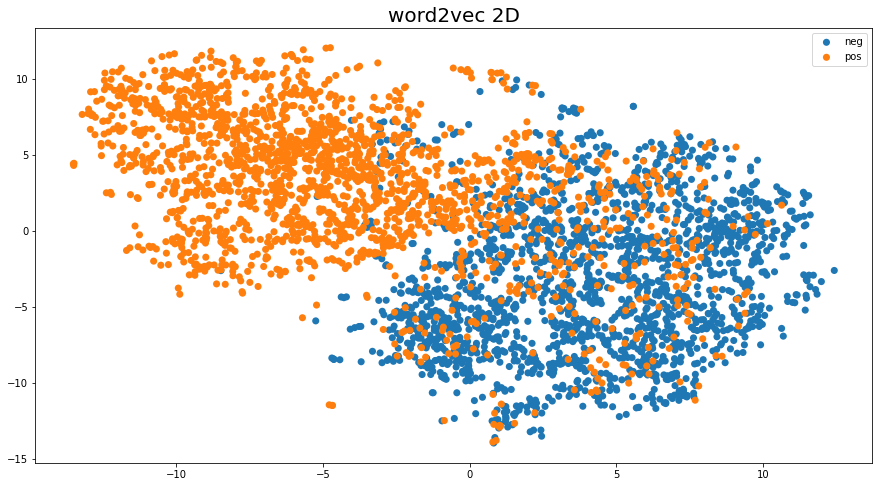

In [250]:
X_tsne_2 = tsne.fit_transform(train_word2vec)

plt.figure(figsize=(15, 8))


plt.scatter(X_tsne_2[:1975, 0],
            X_tsne_2[:1975, 1],
            label='neg', edgecolor='none', s=50)
plt.scatter(X_tsne_2[1975:, 0],
            X_tsne_2[1975:, 1],
            label='pos', edgecolor='none', s=50)
plt.title(u"word2vec 2D", fontsize=20)
plt.legend()

In [251]:
X_tsne_3 = tsne.fit_transform(train_word2vec)

d = {'target': list(data['isPositive']),
    'x': X_tsne_3[:, 0],
    'y': X_tsne_3[:, 1],
    'z': X_tsne_3[:, 2]}
df = pd.DataFrame(data = d)

fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color='target',
                    title="word2vec 3D")

fig.update_layout(width=800, height=800)
fig.show()

C:\Users\proho\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:764: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

C:\Users\proho\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:774: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [252]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(train_word2vec), data['isPositive'], test_size=0.1, random_state=42)

model = XGBClassifier()
model.fit(X_train, y_train)

C:\Users\proho\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[12:48:29] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [253]:
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.9189873417721519

In [254]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=400,
    learning_rate=0.03,
    l2_leaf_reg=3,
    leaf_estimation_method='Newton'
)

model.fit(X_train, y_train,
         verbose=False,
         eval_set=(X_test, y_test),
         plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [255]:
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.9189873417721519

In [257]:
t_m = CatBoostClassifier()
grid = {
    'learning_rate': [0.03, 0.1],
    'depth':[4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}
grid_search_results = t_m.grid_search(grid, 
                                        X = X_train,
                                        y = y_train,
                                        shuffle=False,
                                        verbose=False,
                                        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.1540720737
bestIteration = 938


bestTest = 0.1492411042
bestIteration = 332


bestTest = 0.1580655628
bestIteration = 879


bestTest = 0.1573157484
bestIteration = 315


bestTest = 0.1571418979
bestIteration = 960


bestTest = 0.1561679232
bestIteration = 342


bestTest = 0.1562654796
bestIteration = 969


bestTest = 0.1601246318
bestIteration = 268


bestTest = 0.157705078
bestIteration = 928


bestTest = 0.1569858895
bestIteration = 302


bestTest = 0.1591439965
bestIteration = 435


bestTest = 0.157253106
bestIteration = 147


bestTest = 0.162028068
bestIteration = 498


bestTest = 0.1574566377
bestIteration = 178


bestTest = 0.1565054987
bestIteration = 610


bestTest = 0.1639109909
bestIteration = 202


bestTest = 0.156821133
bestIteration = 645


bestTest = 0.1535457798
bestIteration = 147


bestTest = 0.1606346638
bestIteration = 650


bestTest = 0.159457521
bestIteration = 191


bestTest = 0.1798984784
bestIteration = 336


bestTest = 0.1846877078
bestIteration 

In [259]:
best = CatBoostClassifier(**grid_search_results['params'])

best.fit(X_train, y_train, verbose=False)
preds = best.predict(X_test)
accuracy_score(y_test, preds)

0.9367088607594937

In [260]:
# Проверим что в тестовом наборе баланс классов сохраняется
pd.Series(y_test).value_counts()

0    200
1    195
Name: isPositive, dtype: int64

In [261]:
# Обучим конечную модель на всех данных и сделаем предсказание на тесте
best = CatBoostClassifier(**grid_search_results['params'])

best.fit(np.array(train_word2vec), data['isPositive'], verbose=False)
preds = best.predict(test_word2vec)

In [267]:
pred = {'preds': preds}

pred = pd.DataFrame(data=pred)

In [269]:
pred.head()

,preds
0,0
1,1
2,1
3,0
4,1


In [270]:
pred.to_csv('pred_csv', index=False)